# Round winner prediction in the first-person-shooter game Counter-Strike: Global Offensive (CS:GO)

## Background

Counter-Strike: Global Offensive (CS:GO) is a tactical team-based first-person-shooter game. It is currently one of the most popular esport titles. The most recent Major Championship, ESL Rio 2023, has over 1 million peak concurrent viewers on live streaming platforms, according to statistics published by Esports Charts [1].

In CS:GO, the standard competitive game mode is a best-of-30 match involving two teams, namely Terrorists (Ts) and Counter-Terrorists (CTs).

Each team consists of 5 players. In each round of the match, the objective of the Ts is to carry and plant a bomb at either of two designated bomb sites, while the CTs will attempt to stop the Ts from planting the bomb, or defuse the bomb if it is planted.

Each round begins with the default phase that lasts for 1 minute 55 seconds. The Ts must either eliminate the CTs or plant the bomb during this phase. When the bomb is planted, the round timer stops and a 40-second bomb countdown begins. If the CTs are able to defuse the bomb during the countdown, the CTs win the round. On the other hand, if the CTs are eliminated or cannot defuse the bomb in time, the bomb explodes and the Ts win the round.

Below is an example of a round played on the map called 'de_dust2'. The Ts is represented by red dots, and the CTs are represented by blue dots. An "X" is displayed when a player is eliminated. In this round. the Ts successfully carried the bomb (represented by the orange octagon) to Bombsite A and planted the bomb. The round ended with all CTs being eliminated.

In [1]:
%%html
<center>
<video width="400" height="400" autoplay loop controls>
  <source src="demos/demo_round.mp4" type="video/mp4">
</video><br>
<figcaption>Round 8 of Game 1 of Astralis vs G2 Esports, BLAST Premiere Global Final Day 3, 2021<br>
demoId = 'cfce0ad1-cf97-40a7-a9fc-b530411f8a8d'; round_num = 8</figcaption>
</center>


## Objective of this project
In the supervised learning section, we will train different models to predict the Counter-Terrorist team's winning probability given a frame of the round.

In the unsupervised learning section, we will investigate the effectiveness of PCA and autoencoders in dimensionality reduction.

## Source of data - ESTA dataset
The source of data for this project is the **ES**ports **T**rajectories and **A**ctions (ESTA) dataset. It contains parsed gameplay demos (recorded game data) from professional CS:GO matches between January 2021 and May 2022. The ESTA dataset is released under a CC BY-SA 4.0 license. The dataset is available at https://github.com/pnxenopoulos/esta [2].

The original data is in JSON format. The gameplay data was recorded at 2 frames per second. Each frame is a snapshot of the game state during a round.

For the purpose of this project, the data is preprocessed by parsing it into a data frame format and selecting about 120 features. Each row is a game frame. The features include information about the game state at the time of the frame, per-player information, and also the winning team of the round (the target variable).

Only the matches on the map 'de_dust2' are used for this project.

The Jupyter noteboook used for parsing the data can be found in the Appendix.

## Setup

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# Used for saving and loading models from disk
import joblib

Please check `joblib` version is >=1.2.0, otherwise may not able to load the saved models properly.

In [3]:
print(joblib.__version__)

1.2.0


In [4]:
# Set this to true if we want to re-train all the models, 
# otherwise, the notebook will load the models from saved files
RUN_MODELS_AGAIN = False

# Set this to true if we want to load the full dataset (728 MB)
# Otherwise, the aggregated dataset will be loaded (84 MB compressed)
LOAD_PRUNED_DATASET = True

In [5]:
sns.set_theme()
gpu_available = True if len(tf.config.list_physical_devices('GPU')) > 0 else False

## Exploratory Data Analysis
### Load the data

In [6]:
if LOAD_PRUNED_DATASET == False:
    df = pd.read_csv('esta-de_dust2-new.csv')
    df.info()

### Data Description

In the original dataset, there are 120 columns. Each row is a game frame (a snapshot of the game state).
The target variable is `ctWin`, which takes the value **1** if CT wins the round, and **0** if T wins the round.

The `demoId` is unique to each match, and the `roundNum` column indicates the round that the frame is taken from. The frames of each match appear in sequential order in the dataset.

| Column | Type | Description |
| :- | :- | :- |
| demoId | string | ID of the demo, unique per match |
| roundNum | int | Current round number (1 for the first round in the match) |
| ctWin | int | **Target variable:** 1 if CT wins the round, 0 if T wins the round |
| secondsSincePhaseStart | float | Number of seconds elapsed since the start of the current game phase in each round. Each round starts in the default game phase. If and when the bomb is planted, the game will enter the "bomb planted" phase.
| bombPlanted | bool | Whether the bomb is currently planted |
| bombsite | string | Name of the bombsite where the bomb is currently planted (A / B). `Null` if the bomb is not planted. 
| (t/ct)EquipmentValueStart | int | Total equipment value of T/CT players at the start of the round |
| (t/ct)Alive | int | Total number of T/CT players alive |

For each team (t/ct), for the i-th player on the team, the following features are provided. There are 10 players in total.

| Column | Type | Description |
| :- | :- | :- |
| (t/ct)\_p(i)\_hp | int | Amount of hitpoints (0-100) |
| (t/ct)\_p(i)\_armor | int | Amount of armor (0-100) |
| (t/ct)\_p(i)\_hasHelmet | bool | 1 if the player has a helmet equipped, 0 otherwise. |
| (t/ct)\_p(i)\_equipmentValue | int | Total value of the player's equipment. |
| (t/ct)\_p(i)\_totalUtility | int | Total number of utility grenades in the inventory. |
| (t/ct)\_p(i)\_isInBombZone | bool | 1 if the player is in a bomb site, 0 otherwise. |
| (t/ct)\_p(i)\_(x/y/z) | float | (x/y/z) coordinates of the player's position in the game map |
| t_p(i)\_hasBomb | bool | (For T players only) 1 if the player is carrying the bomb in the inventory, 0 otherwise |
| ct_p(i)\_hasDefuse | bool | (For CT players only) 1 if the player is carrying a defuse kit in the inventory, 0 otherwise |

### Data Aggregation

In the original dataset, some features are listed by each individual player. We aggregate the features of the 5 players on each team to simplify the dataset. The following features are generated by summing the values of each player on the T and CT teams respectively.

- `(t/ct)Hp`: total amount of hitpoints (Hp) of t/ct players
- `(t/ct)Armor`: total amount of armor of t/ct players
- `(t/ct)Helmet`: total number of helmets equipped for t/ct players
- `(t/ct)EquipmentValue`: total equipment value of t/ct players
- `(t/ct)Utility`: total number of utility grenades of t/ct players
- `(t/ct)PlayersInBombZone`: total number of players in the bombzone
- `(t/ct)MeanPos_(x/y/z)`: Mean value of position coordinates of t/ct players
- `(t/ct)StdDevPos_(x/y/z)`: Standard deviation of position coordinates of t/ct players. If one player is left on the team, this value will be zero.
- `ctDefusers`: total number of defuse kits being carried on the CT team
- `tHasBomb`: whether the bomb is being carried by a player on the T team

In [7]:
if LOAD_PRUNED_DATASET == True:
    df = pd.read_csv('esta-de_dust2-aggregated.csv.bz2', compression='bz2')
    
else:
    from src.utils import aggregate_players_info
    
    # It is possible to have RuntimeWarning when team is 't', 
    # since the round continues even if all T players are eliminated if the bomb is already planted
    # The NaN values will be handled later
    df_orig = df.copy()
    df = aggregate_players_info(df_orig)
    df.to_csv('esta-de_dust2-aggregated.csv.bz2', index=False, compression={'method': 'bz2', 'compresslevel': 9})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932743 entries, 0 to 932742
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   secondsSincePhaseStart  932743 non-null  float64
 1   bombPlanted             932743 non-null  int64  
 2   bombsite                156137 non-null  object 
 3   ctAlive                 932743 non-null  int64  
 4   ctEquipmentValueStart   932743 non-null  int64  
 5   tAlive                  932743 non-null  int64  
 6   tEquipmentValueStart    932743 non-null  int64  
 7   ctWin                   932743 non-null  int64  
 8   demoId                  932743 non-null  object 
 9   roundNum                932743 non-null  int64  
 10  ctDefusers              932743 non-null  float64
 11  tHasBomb                932743 non-null  float64
 12  tHp                     932743 non-null  float64
 13  tArmor                  932743 non-null  float64
 14  tHelmet             

In [8]:
# Add a column to identify the round that the frame is in
df['roundIdentifier'] = df['demoId'] + '-' + df['roundNum'].map(str)

# Add a column to identify the frame number in each round, for ease of plotting later
df['frameNumber'] = df.groupby((df['roundIdentifier'] != df['roundIdentifier'].shift(1)).cumsum()).cumcount()+1

In [9]:
df.head()

,secondsSincePhaseStart,bombPlanted,bombsite,ctAlive,ctEquipmentValueStart,tAlive,tEquipmentValueStart,ctWin,demoId,roundNum,...,ctUtility,ctPlayersInBombZone,ctMeanPos_x,ctStdDevPos_x,ctMeanPos_y,ctStdDevPos_y,ctMeanPos_z,ctStdDevPos_z,roundIdentifier,frameNumber
0,0.000000,0,NaN,5,4400,5,4100,1,02742547-7137-4acd-b60f-14d39790c330,1,...,1.0,0.0,257.258597,77.291052,2415.181982,47.179011,-120.566061,0.421008,02742547-7137-4acd-b60f-14d39790c330-1,1
1,0.503937,0,NaN,5,4400,5,4100,1,02742547-7137-4acd-b60f-14d39790c330,1,...,1.0,0.0,259.052658,92.668392,2349.203662,45.581362,-119.820306,0.775449,02742547-7137-4acd-b60f-14d39790c330-1,2
2,1.007874,0,NaN,5,4400,5,4100,1,02742547-7137-4acd-b60f-14d39790c330,1,...,1.0,0.0,245.944811,163.101020,2261.403467,41.851444,-124.862880,3.824497,02742547-7137-4acd-b60f-14d39790c330-1,3
3,1.511811,0,NaN,5,4400,5,4100,1,02742547-7137-4acd-b60f-14d39790c330,1,...,1.0,0.0,223.446132,269.347601,2209.917920,33.489962,-121.304292,11.984621,02742547-7137-4acd-b60f-14d39790c330-1,4
4,2.015748,0,NaN,5,4400,5,4100,1,02742547-7137-4acd-b60f-14d39790c330,1,...,1.0,0.0,199.275380,387.272806,2184.379932,34.865938,-107.232007,25.095097,02742547-7137-4acd-b60f-14d39790c330-1,5


In [10]:
print('Total number of features: {}'.format(df.shape[1]))

print('Total number of matches in the dataset: {}'.format(
    df['demoId'].nunique()))

print('There are {} number of rounds in the dataset.'.format(
    df['roundIdentifier'].nunique()))

Total number of features: 38
Total number of matches in the dataset: 197
There are 5178 number of rounds in the dataset.


In [11]:
df.describe(include='object').T

,count,unique,top,freq
bombsite,156137,2,A,88951
demoId,932743,197,6f0223a1-f883-4638-8e12-7385de49aeaa,8666
roundIdentifier,932743,5178,3ab34bf1-dc97-45bd-87fc-b92234bbdd11-13,309


`bombsite` can be `null` (if the bomb is not planted), 'A' or 'B'. The `demoId` is not useful as a predictor, but will be useful when splitting into the training and test datasets.

In [12]:
df.isna().sum()

secondsSincePhaseStart         0
bombPlanted                    0
bombsite                  776606
ctAlive                        0
ctEquipmentValueStart          0
tAlive                         0
tEquipmentValueStart           0
ctWin                          0
demoId                         0
roundNum                       0
ctDefusers                     0
tHasBomb                       0
tHp                            0
tArmor                         0
tHelmet                        0
tEquipmentValue                0
tUtility                       0
tPlayersInBombZone             0
tMeanPos_x                 36467
tStdDevPos_x               36467
tMeanPos_y                 36467
tStdDevPos_y               36467
tMeanPos_z                 36467
tStdDevPos_z               36467
ctHp                           0
ctArmor                        0
ctHelmet                       0
ctEquipmentValue               0
ctUtility                      0
ctPlayersInBombZone            0
ctMeanPos_

There are no missing values except for the `bombsite` column and the player position columns of the Terrorist team.
- For the `bombsite` column, it will be `null` if the bomb is not planted.
- For the columns related to players' positions, it will be `null` when all players on the team are eliminated but the round is still in progress. This can occur when all Terrorist players are eliminated but the Counter-Terrorists have not yet defused the bomb. Since the bomb defusal takes a certain amount of time, the CT team can still lose in this situation if they cannot defuse the bomb in time.

### Data visualization
This section performs exploratory data analysis of the target variable `ctWin`, as well as its relationship with the number of players alive and the total equipment value on each team.

#### Target variable: `ctWin`
The count plot below shows that the dataset is balanced. There are approximately equal number of frames from rounds where CT wins and rounds where CT loses.

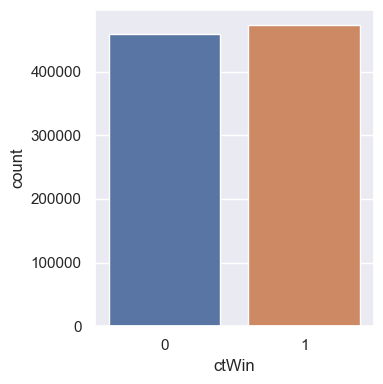

In [13]:
f, a = plt.subplots(figsize=(4,4))
sns.countplot(data=df, x='ctWin')
plt.tight_layout()

#### Number of players alive on each team: `tAlive` and `ctAlive`
The heat map below shows the proportion of game frames from rounds where CTs wins, for different number of players alive on each team. We can observe that:
- The number of players remaining is an important factor in determining the round outcome. The team with the more players alive is favored to win.
- As mentioned above, if the bomb has been planted, the round will not end instantly even if all Terrorist players are eliminated. Hence, there are records corresponding to zero T-players alive in the dataset.

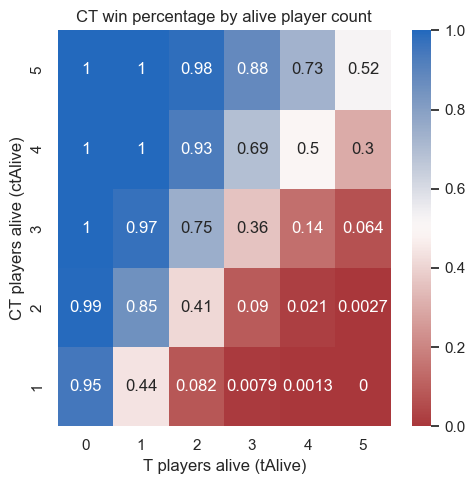

In [14]:
f, a = plt.subplots(figsize=(5, 5))
sns.heatmap(df.groupby(by=['ctAlive', 'tAlive']).mean()['ctWin'].unstack(), annot=True, cmap="vlag_r")
plt.title('CT win percentage by alive player count')
a.invert_yaxis()
plt.xlabel('T players alive (tAlive)')
plt.ylabel('CT players alive (ctAlive)')
plt.tight_layout()

#### Total equipment value on each team: `tEquipmentValue` and `ctEquipmentValue`
The code below further investigates the relationship between the equipment value and the CT winning probability, since the team with the more expensive equipment (hence more powerful weapons) will usually win the round, even when the number of players alive are equal.

The plot below shows the proportion of game frames where CT wins the round for different average equipment value of the players. The team with the higher equipment value is favored to win. It is also worth noting that when the equipment value is equal, the odds favor the Terrorist team. This is consistent with generally accepted game knowledge that the equipment cost of the CT team is more expensive.

There are some inconsistent trends on the edge of the heatmap. Each of those observations account for less than 1% of the data, so it is likely to be outliers.

In [15]:
# Compute the average equipment value (the total equipment value divided by number of players alive)
meanEqValue = pd.DataFrame({f'{team}MeanEqValue': np.divide(df[f'{team}EquipmentValue'], df[f'{team}Alive'],
                                                            out=np.zeros_like(df[f'{team}EquipmentValue']),
                                                            where=df[f'{team}Alive'] != 0)
                            for team in ['t', 'ct']})

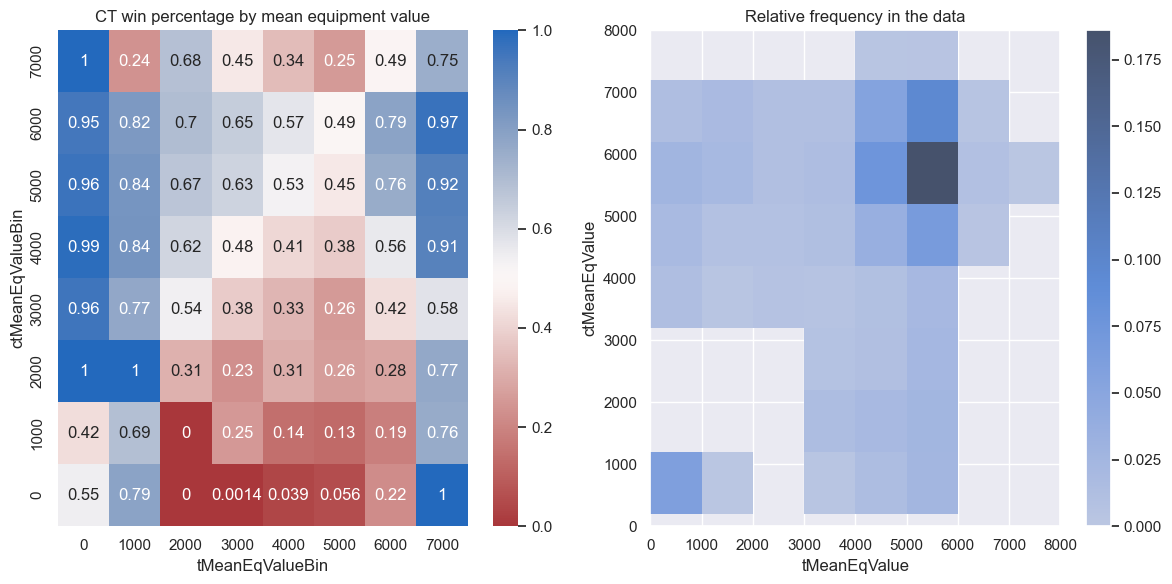

In [16]:
cuts = pd.DataFrame({str(feature) + 'Bin': pd.cut(df.join(meanEqValue)
                    [feature], np.arange(0, 9000, 1000)) for feature in ['tMeanEqValue', 'ctMeanEqValue']})
means = df.join(meanEqValue).join(cuts).groupby(
    list(cuts)).mean()['ctWin'].unstack()
f, a = plt.subplots(ncols=2, figsize=(12, 6))

sns.heatmap(data=means.T,
            xticklabels=means.columns.map(lambda x: x.left),
            yticklabels=means.index.map(lambda x: x.left),
            annot=True, cmap="vlag_r", ax=a[0])
a[0].set_title('CT win percentage by mean equipment value')
a[0].invert_yaxis()

sns.histplot(data=df.join(meanEqValue).join(cuts), x='tMeanEqValue', y='ctMeanEqValue',
             binwidth=1000, stat='proportion', pthresh=0.01, cbar=True, ax=a[1])
a[1].set(xlim=(0, 8000))
a[1].set(ylim=(0, 8000))
a[1].set_title('Relative frequency in the data')
plt.tight_layout()


## Supervised Learning

For the supervised learning task, we are interested in predicting the probability of CT winning the round given a game frame. The target variable is `ctWin`, which takes the value 1 if CT wins the round, and 0 if T wins the round.

### Data preprocessing

#### Prepare the training and test sets

We should ensure that the frames from same round is not present in both training and test sets, otherwise there would be data leakage.

 From the dataset, `demoId` is the id for the match, and `roundNum` is the round number during the match. The combination of `demoId`-`roundNum` identifies a unique round.

We hold out 20% of the rounds as the test set.

In [17]:
# This creates a list of rounds and the corresponding ctWin for that round
rounds_list = pd.DataFrame(df.groupby(by='roundIdentifier').first()['ctWin'])
rounds_list.reset_index(inplace=True)
rounds_list.head()

,roundIdentifier,ctWin
0,00e7fec9-cee0-430f-80f4-6b50443ceacd-1,0
1,00e7fec9-cee0-430f-80f4-6b50443ceacd-10,1
2,00e7fec9-cee0-430f-80f4-6b50443ceacd-11,0
3,00e7fec9-cee0-430f-80f4-6b50443ceacd-12,0
4,00e7fec9-cee0-430f-80f4-6b50443ceacd-13,0


In [18]:
# Perform stratified split on the list of rounds
from sklearn.model_selection import train_test_split

rounds_train, rounds_test = train_test_split(
    rounds_list, test_size=0.2, random_state=20221116, stratify=rounds_list['ctWin'])

print('There are {} rounds in training set.'.format(rounds_train.shape[0]))
print('Proportion of CT wins: {:.4f}'.format(np.mean(rounds_train['ctWin'])))
print()
print('There are {} rounds in test set.'.format(rounds_test.shape[0]))
print('Proportion of CT wins: {:.4f}'.format(np.mean(rounds_test['ctWin'])))


There are 4142 rounds in training set.
Proportion of CT wins: 0.5215

There are 1036 rounds in test set.
Proportion of CT wins: 0.5212


In [19]:
df_train = df.copy()
df_train = df_train[df_train['roundIdentifier'].isin(rounds_train['roundIdentifier'])]
print('Shape of the training set: {}'.format(df_train.shape))

df_test = df.copy()
df_test = df_test[df_test['roundIdentifier'].isin(rounds_test['roundIdentifier'])]
print('Shape of the test set: {}'.format(df_test.shape))

Shape of the training set: (744964, 38)
Shape of the test set: (187779, 38)


#### Handle missing values for bombsite column
These rows correspond to game states where the bomb is not planted. We use a simple mapping to convert to the column to ordinal values and handle the missing values:
- `-1` if the bomb is not planted
- `0` if the bomb is planted in bombsite A
- `1` if the bomb is planted in bombsite B

In [20]:
bombsite_mapping = {np.nan: -1, 'A': 0, 'B': 1}
df_train['bombsite'] = df_train['bombsite'].map(bombsite_mapping)
df_test['bombsite'] = df_test['bombsite'].map(bombsite_mapping)

#### Handle missing values for aggregated player coordinates
These rows correspond to the game states where all T players are eliminated. To handle these missing values, we create a new boolean column to indicate whether all T players are eliminated. We use the mean to impute missing values.

In [21]:
print('Before imputation:')
df_train[[f't{a}Pos_{ax}' for a in ['Mean', 'StdDev'] for ax in ['x', 'y', 'z']]].describe()

Before imputation:


,tMeanPos_x,tMeanPos_y,tMeanPos_z,tStdDevPos_x,tStdDevPos_y,tStdDevPos_z
count,715418.000000,715418.000000,715418.000000,715418.000000,715418.000000,715418.000000
mean,-221.287999,1085.579562,13.204372,472.148197,425.090599,38.334681
std,879.128237,812.857461,46.730140,320.985848,278.778795,27.055731
min,-2185.999756,-1163.996582,-181.998718,0.000000,0.000000,0.000000
25%,-796.672957,580.009034,-14.266646,199.094364,204.069662,14.048548
50%,-289.296519,1076.288040,9.946172,454.669811,417.419446,41.549283
75%,404.909312,1666.139394,38.370907,719.084084,605.617200,57.929077
max,1787.999878,3117.995117,223.943253,1965.197144,1784.534258,163.356892


In [22]:
# Create a new boolean column
df_train['all_t_players_eliminated'] = np.where(df_train['tAlive'] == 0, 1, 0)
df_test['all_t_players_eliminated'] = np.where(df_test['tAlive'] == 0, 1, 0)

# Impute with mean from the training set
for col in [f't{a}Pos_{ax}' for a in ['Mean', 'StdDev'] for ax in ['x', 'y', 'z']]:
    mean_val = df_train[col].mean()
    df_train[col].fillna(value=mean_val, inplace=True)
    df_test[col].fillna(value=mean_val, inplace=True)

print('After imputation:')
df_train[[f't{a}Pos_{ax}' for a in ['Mean', 'StdDev'] for ax in ['x', 'y', 'z']]].describe()

After imputation:


,tMeanPos_x,tMeanPos_y,tMeanPos_z,tStdDevPos_x,tStdDevPos_y,tStdDevPos_z
count,744964.000000,744964.000000,744964.000000,744964.000000,744964.000000,744964.000000
mean,-221.287999,1085.579562,13.204372,472.148197,425.090599,38.334681
std,861.518297,796.575000,45.794082,314.556136,273.194539,26.513774
min,-2185.999756,-1163.996582,-181.998718,0.000000,0.000000,0.000000
25%,-768.642470,604.952201,-12.815085,208.819194,213.370589,14.595381
50%,-242.478094,1085.579562,11.869752,472.148197,425.090599,39.587553
75%,375.595952,1631.337830,36.562516,708.334525,595.991421,57.155494
max,1787.999878,3117.995117,223.943253,1965.197144,1784.534258,163.356892


### Data normalization

In [23]:
# Split into X and y
X_train = df_train.drop('ctWin', axis=1)
y_train = df_train['ctWin']
X_test = df_test.drop('ctWin', axis=1)
y_test = df_test['ctWin']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(744964, 38) (744964,) (187779, 38) (187779,)


View the numeric data before normalization.

In [24]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
secondsSincePhaseStart,744964.0,38.208898,27.418381,0.000000,15.585938,32.622047,57.195312,114.992126
bombPlanted,744964.0,0.168222,0.374063,0.000000,0.000000,0.000000,0.000000,1.000000
bombsite,744964.0,-0.760037,0.570846,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
ctAlive,744964.0,3.941386,1.301012,1.000000,3.000000,5.000000,5.000000,5.000000
ctEquipmentValueStart,744964.0,22922.760496,9781.477149,1000.000000,17700.000000,26800.000000,30450.000000,35700.000000
tAlive,744964.0,3.833430,1.468247,0.000000,3.000000,4.000000,5.000000,5.000000
tEquipmentValueStart,744964.0,20485.173914,8509.809056,1000.000000,16950.000000,24000.000000,27050.000000,36150.000000
roundNum,744964.0,13.989842,8.184552,1.000000,7.000000,13.000000,20.000000,48.000000
ctDefusers,744964.0,1.670887,1.523090,0.000000,0.000000,1.000000,3.000000,5.000000
tHasBomb,744964.0,0.670781,0.469930,0.000000,0.000000,1.000000,1.000000,1.000000


We proceed with the data normalization below.
- We can passthrough the `bombsite` column since it is a nominal variable, being either -1, 0, +1 for bomb not planted, planted in bombsite A, planted in bombsite B respectively.
- We normalize the numeric features using `MinMaxScaler`.
- We drop the id columns. We also drop the columns for equipment value at the start of the round, since we will use the equipment value at every game frame.

In [25]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer

ignore_vars = ['bombsite']
cat_vars = []
drop_vars = ['frameNumber', 'roundNum', 'demoId', 'roundIdentifier', 'ctEquipmentValueStart', 'tEquipmentValueStart']
num_vars = [c for c in X_train.columns if (c not in cat_vars) and (c not in drop_vars) and (c not in ignore_vars)]

ct = make_column_transformer(
    (OneHotEncoder(), cat_vars),
    (MinMaxScaler(), num_vars),
    ('drop', drop_vars),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [26]:
# Restore the feature names to the normalized dataset
X_train = pd.DataFrame(ct.fit_transform(X_train), columns=ct.get_feature_names_out())
X_test = pd.DataFrame(ct.transform(X_test), columns=ct.get_feature_names_out())

After normalization, the numeric features are in the same order of magnitude.

In [27]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
secondsSincePhaseStart,744964.0,0.332274,0.238437,0.0,0.135539,0.283689,0.497385,1.0
bombPlanted,744964.0,0.168222,0.374063,0.0,0.000000,0.000000,0.000000,1.0
ctAlive,744964.0,0.735347,0.325253,0.0,0.500000,1.000000,1.000000,1.0
tAlive,744964.0,0.766686,0.293649,0.0,0.600000,0.800000,1.000000,1.0
ctDefusers,744964.0,0.334177,0.304618,0.0,0.000000,0.200000,0.600000,1.0
tHasBomb,744964.0,0.670781,0.469930,0.0,0.000000,1.000000,1.000000,1.0
tHp,744964.0,0.699423,0.314163,0.0,0.464000,0.800000,1.000000,1.0
tArmor,744964.0,0.649188,0.319135,0.0,0.400000,0.754000,0.948000,1.0
tHelmet,744964.0,0.613790,0.370580,0.0,0.200000,0.800000,1.000000,1.0
tEquipmentValue,744964.0,0.440790,0.242929,0.0,0.228802,0.484522,0.666218,1.0


### Setup for Modeling

In [28]:
# Make a copy of the dataframes to store the prediction results later
df_train_result = df_train.copy()
df_test_result = df_test.copy()

In [29]:
# Reports the best scores from the searched models
# https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn/notebook
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [30]:
def plot_cv_results(cv_results):
    cv_scores = pd.DataFrame(cv_results).sort_values(
        by='rank_test_score')[['rank_test_score', 'mean_test_score', 'std_test_score']]

    plt.scatter(cv_scores['rank_test_score'], cv_scores['mean_test_score'])
    plt.title('CV score for each model (higher is better)')
    plt.xlabel('Model Rank')
    plt.ylabel('Accuracy')
    plt.tight_layout()


In [31]:
def results_df(y_pred_proba, y_pred, colnames=None, provide_index=None):
    df_result = pd.DataFrame({'y_pred_proba': y_pred_proba,
                              'y_pred': y_pred})
    if colnames is not None:
        df_result.columns = colnames

    if provide_index is not None:
        df_result.index = provide_index

    return df_result


In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, log_loss, classification_report

def evaluate_model(y_true, y_pred_proba, y_pred=None):
    if len(y_pred) == 0:
        y_pred = round(y_pred_proba)
    print('log-loss: {:.4f}'.format(log_loss(y_true, y_pred_proba)))
    print(classification_report(y_true, y_pred))

    fig, ax = plt.subplots(ncols=2, figsize=(10,4))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax[0])

    # ROC curve
    RocCurveDisplay.from_predictions(y_true, y_pred_proba, ax=ax[1])
    plt.tight_layout()

We specify a Group K-Fold cross validation scheme here, to be used later. The reason is that it is not desirable to have frames from the same round appearing in both training and validation sets.

In [33]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=5)
groups = df_train['roundIdentifier']

### Logistic Regression
First, we consider the logistic regression model. Cross-validation is used to tune the L2 regularization penalty.

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [35]:
params = {
    'C': [0.01, 0.1, 1, 10],
}

logistic_clf_search = GridSearchCV(LogisticRegression(random_state=0, max_iter=200), params, verbose=1, cv=group_kfold)

In [36]:
%%time
if RUN_MODELS_AGAIN == True:
    logistic_clf_search.fit(X_train, y_train, groups=groups)
    joblib.dump(logistic_clf_search, 'models/logistic_clf_search.joblib')
else:
    logistic_clf_search = joblib.load('models/logistic_clf_search.joblib')
    
report_best_scores(logistic_clf_search.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.7575 (std: 0.0119)
Parameters: {'C': 0.1}

Model with rank: 2
Mean validation score: 0.7575 (std: 0.0118)
Parameters: {'C': 10}

Model with rank: 3
Mean validation score: 0.7575 (std: 0.0118)
Parameters: {'C': 1}

CPU times: total: 0 ns
Wall time: 1.96 ms


In [37]:
%%time
if RUN_MODELS_AGAIN == True:
    # Get the best model from the search and fit again
    logistic_clf_model = logistic_clf_search.best_estimator_
    
    logistic_clf_model.fit(X_train, y_train)
    joblib.dump(logistic_clf_model, 'models/logistic_clf_trained_model.joblib')
else:
    logistic_clf_model = joblib.load('models/logistic_clf_trained_model.joblib')

CPU times: total: 0 ns
Wall time: 997 µs


In [38]:
# Save the predictions to a dataset for training data
p_train = results_df(
    y_pred_proba=logistic_clf_model.predict_proba(X_train)[:, 1],
    y_pred=logistic_clf_model.predict(X_train),
    colnames=['ctWin_proba', 'ctWin'],
    provide_index=df_train.index)

df_train_result['logistic_clf_ctWin_proba'] = p_train['ctWin_proba']
df_train_result['logistic_clf_ctWin'] = p_train['ctWin']

In [39]:
# Save the predictions to a dataset for test data
p_test = results_df(
    y_pred_proba=logistic_clf_model.predict_proba(X_test)[:, 1],
    y_pred=logistic_clf_model.predict(X_test),
    colnames=['ctWin_proba', 'ctWin'],
    provide_index=df_test.index)

df_test_result['logistic_clf_ctWin_proba'] = p_test['ctWin_proba']
df_test_result['logistic_clf_ctWin'] = p_test['ctWin']

log-loss: 0.4440
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     92482
           1       0.75      0.81      0.78     95297

    accuracy                           0.76    187779
   macro avg       0.77      0.76      0.76    187779
weighted avg       0.77      0.76      0.76    187779



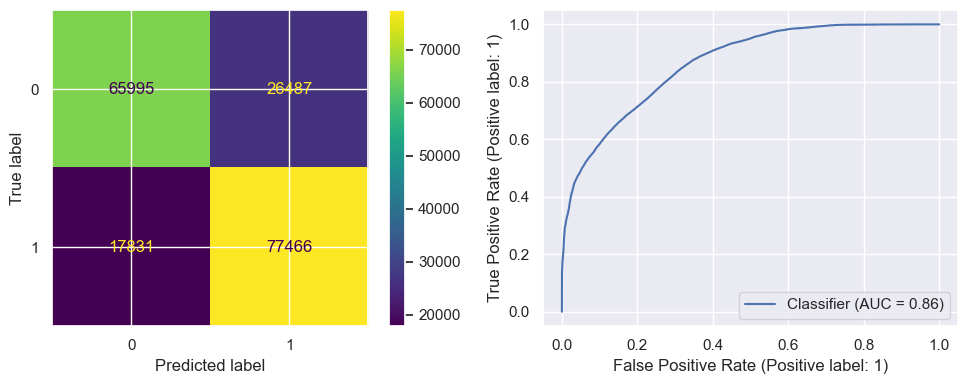

In [40]:
evaluate_model(df_test_result['ctWin'], df_test_result['logistic_clf_ctWin_proba'], df_test_result['logistic_clf_ctWin'])

### Decision Tree Classifier
Here we train a decision tree model. Cross-validation is used below to tune the maximum depth of the decision tree.

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [42]:
params = {
    'max_depth': range(2, 13, 2),
}

dt_search = GridSearchCV(DecisionTreeClassifier(random_state=0), params, verbose=1, cv=group_kfold)

In [43]:
%%time
if RUN_MODELS_AGAIN == True:
    dt_search.fit(X_train, y_train, groups=groups)
    # Save the result
    joblib.dump(dt_search, 'models/dt_gridsearch.joblib')
else:
    dt_search = joblib.load('models/dt_gridsearch.joblib')

CPU times: total: 0 ns
Wall time: 1.97 ms


Model with rank: 1
Mean validation score: 0.7457 (std: 0.0124)
Parameters: {'max_depth': 6}



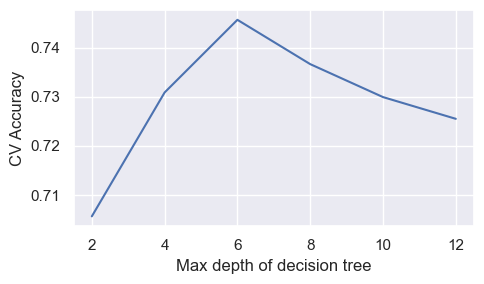

In [44]:
report_best_scores(dt_search.cv_results_, 1)
plt.subplots(figsize=(5,3))
plt.plot(pd.DataFrame(dt_search.cv_results_)['param_max_depth'], pd.DataFrame(dt_search.cv_results_)['mean_test_score'])
plt.xlabel('Max depth of decision tree')
plt.ylabel('CV Accuracy')
plt.tight_layout()

In [45]:
# Get the best model from the search
dt_model = dt_search.best_estimator_

After obtaining the optimal parameter, we re-train the model using the full training dataset.

In [46]:
%%time
if RUN_MODELS_AGAIN == True:
    # Retrain the model using the full training dataset
    dt_model.fit(X_train, y_train)
    joblib.dump(dt_model, 'models/dt_trained_model.joblib')
else:
    dt_model = joblib.load('models/dt_trained_model.joblib')

CPU times: total: 0 ns
Wall time: 960 µs


In [47]:
# Save the predictions to a dataset for training data
p_train = results_df(
    y_pred_proba=dt_model.predict_proba(X_train)[:, 1],
    y_pred=dt_model.predict(X_train),
    colnames=['ctWin_proba', 'ctWin'],
    provide_index=df_train.index)

df_train_result['dt_ctWin_proba'] = p_train['ctWin_proba']
df_train_result['dt_ctWin'] = p_train['ctWin']

In [48]:
# Save the predictions to a dataset for test data
p_test = results_df(
    y_pred_proba=dt_model.predict_proba(X_test)[:, 1],
    y_pred=dt_model.predict(X_test),
    colnames=['ctWin_proba', 'ctWin'],
    provide_index=df_test.index)

df_test_result['dt_ctWin_proba'] = p_test['ctWin_proba']
df_test_result['dt_ctWin'] = p_test['ctWin']

The model evaluation is shown below.

log-loss: 0.4828
              precision    recall  f1-score   support

           0       0.83      0.62      0.71     92482
           1       0.70      0.87      0.78     95297

    accuracy                           0.75    187779
   macro avg       0.76      0.75      0.74    187779
weighted avg       0.76      0.75      0.74    187779



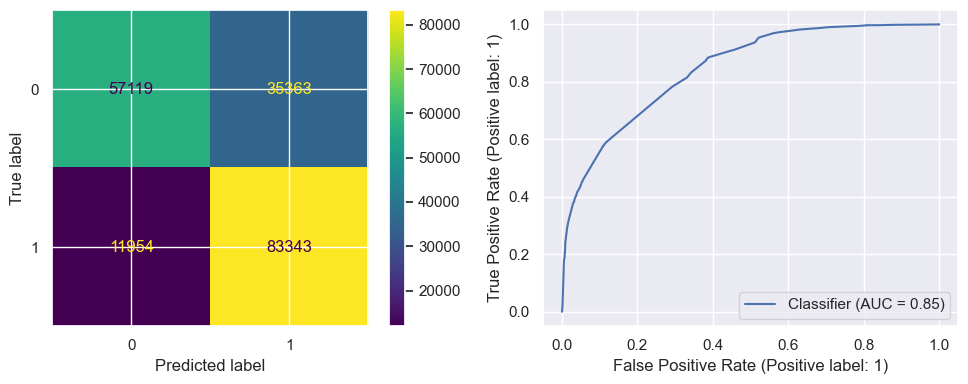

In [49]:
evaluate_model(df_test_result['ctWin'], df_test_result['dt_ctWin_proba'], df_test_result['dt_ctWin'])

Feature importance:

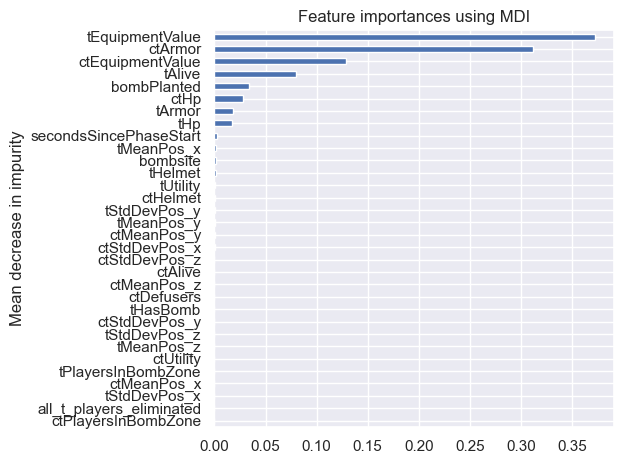

In [50]:
importances = pd.Series(dt_model.feature_importances_, index=ct.get_feature_names_out())
importances.sort_values(inplace=True)

fig, ax = plt.subplots()
importances.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### XGBoost Model (Tree Ensemble Method)
Next, we consider tree ensemble methods. We use XGBoost which is a tree boosting algorithm.

In [51]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

Hyperparameter tuning using `RandomizedSearchCV` cross validation method.

In [52]:
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.01, 0.5),  # default 0.1
    "max_depth": randint(2, 6),  # default 3
    "n_estimators": randint(100, 200),  # default 100
    "subsample": uniform(0.6, 0.4)
}

xgb_search = RandomizedSearchCV(xgb.XGBClassifier(tree_method='gpu_hist' if gpu_available else 'auto'), param_distributions=params, random_state=0,
                                n_iter=50, cv=group_kfold, scoring='accuracy', verbose=1)


In [53]:
%%time
if RUN_MODELS_AGAIN == True:
    xgb_search.fit(X_train, y_train, groups=groups)
    # Save the result to disk
    joblib.dump(xgb_search, 'models/xgb_randomizedsearch.joblib')
else:
    xgb_search = joblib.load('models/xgb_randomizedsearch.joblib')    

report_best_scores(xgb_search.cv_results_, 1)

Model with rank: 1
Mean validation score: 0.7627 (std: 0.0128)
Parameters: {'colsample_bytree': 0.9858374970915833, 'gamma': 0.34374413819390764, 'learning_rate': 0.11775383855677922, 'max_depth': 3, 'n_estimators': 132, 'subsample': 0.8923423227080631}

CPU times: total: 0 ns
Wall time: 11 ms


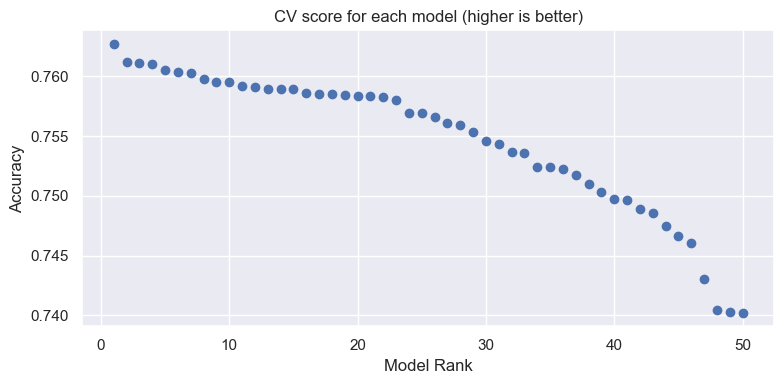

In [54]:
plt.subplots(figsize=(8,4))
plot_cv_results(xgb_search.cv_results_)

In [55]:
xgb_model = xgb_search.best_estimator_

We train the xgb model again using the full training dataset.

In [56]:
%%time
if RUN_MODELS_AGAIN == True:
    xgb_model.fit(X_train, y_train)
    # Save the result to disk
    joblib.dump(xgb_model, 'models/xgb_trained_model.joblib')
else:
    xgb_model = joblib.load('models/xgb_trained_model.joblib')   

CPU times: total: 0 ns
Wall time: 2.96 ms


In [57]:
# Get the predictions for the training set
p_train = results_df(
    y_pred_proba=xgb_model.predict_proba(X_train)[:, 1],
    y_pred=xgb_model.predict(X_train),
    colnames=['ctWin_proba', 'ctWin'],
    provide_index=df_train.index)

df_train_result['xgb_ctWin_proba'] = p_train['ctWin_proba']
df_train_result['xgb_ctWin'] = p_train['ctWin']


In [58]:
# Get the predictions for the test set
p_test = results_df(
    y_pred_proba=xgb_model.predict_proba(X_test)[:, 1],
    y_pred=xgb_model.predict(X_test),
    colnames=['ctWin_proba', 'ctWin'],
    provide_index=df_test.index)

df_test_result['xgb_ctWin_proba'] = p_test['ctWin_proba']
df_test_result['xgb_ctWin'] = p_test['ctWin']

Model evaluation:

log-loss: 0.4388
              precision    recall  f1-score   support

           0       0.80      0.69      0.74     92482
           1       0.74      0.83      0.78     95297

    accuracy                           0.76    187779
   macro avg       0.77      0.76      0.76    187779
weighted avg       0.77      0.76      0.76    187779



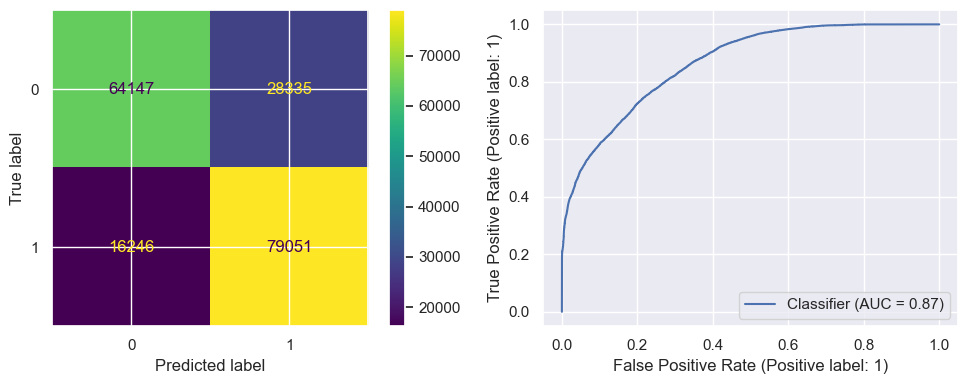

In [59]:
evaluate_model(df_test_result['ctWin'], df_test_result['xgb_ctWin_proba'], df_test_result['xgb_ctWin'])

Feature importance plot:

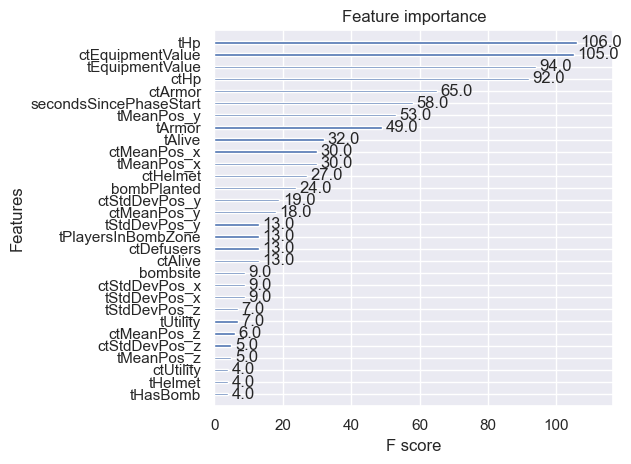

In [60]:
xgb.plot_importance(xgb_model)
plt.tight_layout()

### Neural Network Model (TensorFlow)
For the third type of model, we consider a fully connected neural network using TensorFlow.

In [61]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L2

import keras_tuner as kt

In [62]:
def build_and_compile_model(hp):

    n_features = X_train.shape[1]

    model = Sequential()
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=96, step=16)
    hp_float_1 = hp.Float('alpha', min_value=1e-2, max_value=1, sampling='log')

    model.add(Dense(units=hp_units_1, activation='relu', input_shape=(n_features,)))
    model.add(Dense(units=16, activation='relu', kernel_regularizer=L2(hp_float_1)))
    model.add(Dense(1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2], ordered=True)

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=['accuracy'])
    return model

In [63]:
def plot_loss(history):
    # plot learning curves
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross-entropy')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.tight_layout()

The Keras tuner is used to tune the model parameters, namely the width of the first hidden layer, the learning rate, and the regularization parameter.

In [64]:
tuner = kt.Hyperband(build_and_compile_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='kt',
                     project_name='kt',
                     overwrite=RUN_MODELS_AGAIN)

INFO:tensorflow:Reloading Oracle from existing project kt\kt\oracle.json
INFO:tensorflow:Reloading Tuner from kt\kt\tuner0.json


In [65]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 16, 'sampling': None}
alpha (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 1.0, 'step': None, 'sampling': 'log'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [66]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=128, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first densely-connected layer is {best_hps.get('units_1')}.
The optimal L2-regularizer param is {best_hps.get('alpha')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The optimal number of units in the first densely-connected layer is 64.
The optimal L2-regularizer param is 0.1510909076392911.
The optimal learning rate for the optimizer is 0.01.



In [67]:
tf_model = tuner.hypermodel.build(best_hps)
tf_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,169
Trainable params: 3,169
Non-trainable params: 0
_________________________________________________________________


Use 20% validation split to find the optimal number of epochs to train.

In [68]:
if RUN_MODELS_AGAIN == True:
    history = tf_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))

    plt.subplots(figsize=(7,4))
    plot_loss(history)

Re-train the model using the optimal number of epochs.

In [69]:
if RUN_MODELS_AGAIN == True:
    # Re-train the model
    tf_model = tuner.hypermodel.build(best_hps)
    history = tf_model.fit(X_train, y_train, epochs=best_epoch, batch_size=128)
    # Save the model
    tf_model.save('models/tf_model')
else:
    tf_model = tf.keras.models.load_model('models/tf_model')


In [70]:
# Predictions on the training set
tf_pred_proba = tf_model.predict(X_train).flatten()

p_train = results_df(
    y_pred_proba=tf_pred_proba,
    y_pred=np.round(tf_pred_proba),
    colnames=['ctWin_proba', 'ctWin'],
    provide_index=df_train_result.index)

df_train_result['tf_ctWin_proba'] = p_train['ctWin_proba']
df_train_result['tf_ctWin'] = p_train['ctWin']


23281/23281 [==============================] - 17s 710us/step


In [71]:
# Predictions on the test set
tf_pred_proba = tf_model.predict(X_test).flatten()

p_test = results_df(
    y_pred_proba=tf_pred_proba,
    y_pred=np.round(tf_pred_proba),
    colnames=['ctWin_proba', 'ctWin'],
    provide_index=df_test_result.index)

df_test_result['tf_ctWin_proba'] = p_test['ctWin_proba']
df_test_result['tf_ctWin'] = p_test['ctWin']


5869/5869 [==============================] - 4s 723us/step


log-loss: 0.4440
              precision    recall  f1-score   support

           0       0.87      0.59      0.70     92482
           1       0.70      0.91      0.79     95297

    accuracy                           0.76    187779
   macro avg       0.78      0.75      0.75    187779
weighted avg       0.78      0.76      0.75    187779



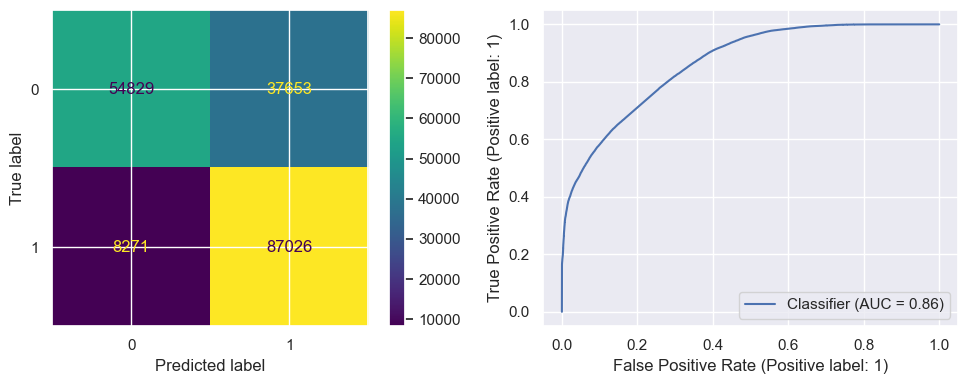

In [72]:
evaluate_model(df_test_result['ctWin'], df_test_result['tf_ctWin_proba'], df_test_result['tf_ctWin'])

### Neural Network Model (FastAI)
For interest, we also investigate the effectiveness of another neural network model, using the Tabular Learner from FastAI but without any fine-tuning.

In [73]:
from fastai.tabular.all import *

In [74]:
# Use 20% as validation
splits = RandomSplitter(valid_pct=0.2)(range_of(df_train))

to = TabularPandas(df_train.drop(drop_vars, axis=1),
                   procs=[Categorify, FillMissing, Normalize],
                   cont_names=[c for c in df_train.columns if (c not in cat_vars) and (
                       c not in drop_vars) and (c not in ['all_t_players_eliminated', 'bombsite', 'ctWin'])],
                   cat_names=['all_t_players_eliminated', 'bombsite'],
                   y_names='ctWin',
                   y_block=CategoryBlock(),
                   splits=splits,
                   )

dls = to.dataloaders(bs=128)

In [75]:
learn = tabular_learner(dls, metrics=accuracy)
learn.summary()

TabularModel (Input shape: 128 x 2)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 3             
Embedding                                 9          True      
Embedding                                 12         True      
Dropout                                                        
BatchNorm1d                               60         True      
____________________________________________________________________________
                     128 x 200           
Linear                                    7200       True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     128 x 100           
Linear                                    20000      True      
ReLU                                                           
BatchNorm1d                               20

In [76]:
%%time
if RUN_MODELS_AGAIN == True:
    learn.fit_one_cycle(5, cbs=[ShowGraphCallback()])
    # Save the model to disk
    learn.save('fastai_saved_model')
else:
    learn.load('fastai_saved_model')

CPU times: total: 0 ns
Wall time: 4.99 ms


In [77]:
# Get predictions on the training set
dl = learn.dls.test_dl(df_train.drop(drop_vars, axis=1))
fastai_pred_proba, _ = learn.get_preds(dl=dl)

p_train = results_df(
    y_pred_proba=fastai_pred_proba[:, 1],
    y_pred=np.round(fastai_pred_proba[:, 1]),
    colnames=['fastai_ctWin_proba', 'fastai_ctWin'],
    provide_index=df_train_result.index)

df_train_result['fastai_ctWin_proba'] = p_train['fastai_ctWin_proba']
df_train_result['fastai_ctWin'] = p_train['fastai_ctWin']

In [78]:
# Get predictions on the test set
dl = learn.dls.test_dl(df_test.drop(drop_vars, axis=1))
fastai_pred_proba, _ = learn.get_preds(dl=dl)

p_test = results_df(
    y_pred_proba=np.array(fastai_pred_proba[:, 1], dtype="float64"),
    y_pred=np.array(np.round(fastai_pred_proba[:, 1]), dtype="float64"),
    colnames=['fastai_ctWin_proba', 'fastai_ctWin'],
    provide_index=df_test_result.index)

df_test_result['fastai_ctWin_proba'] = p_test['fastai_ctWin_proba']
df_test_result['fastai_ctWin'] = p_test['fastai_ctWin']


log-loss: 0.6563
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     92482
           1       0.74      0.74      0.74     95297

    accuracy                           0.73    187779
   macro avg       0.73      0.73      0.73    187779
weighted avg       0.73      0.73      0.73    187779



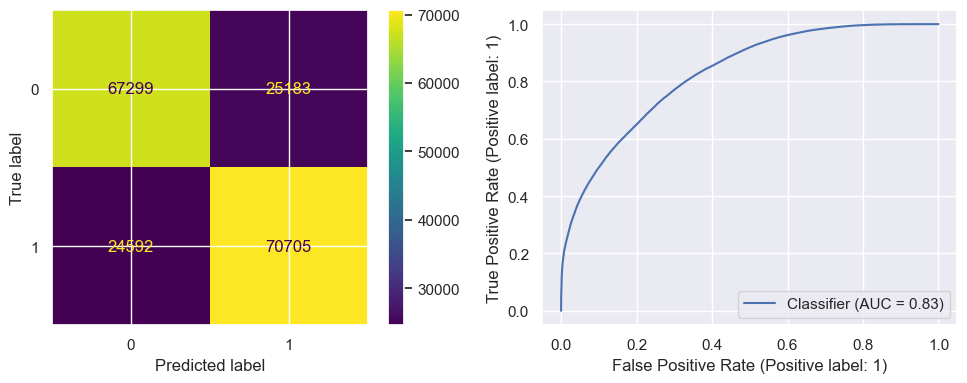

In [79]:
evaluate_model(df_test_result['ctWin'], df_test_result['fastai_ctWin_proba'], df_test_result['fastai_ctWin'])

## Model Comparison

### Evaluation using log-loss and accuracy
The XGBoost model is the best model based on log-loss on the test set. It is an ensemble method and has a decent improvement over the single tree model.

The logistic regression model and TensorFlow's neural network model have similar performance, only slightly worse than the XGBoost model.

However, the FastAI model performs very poorly. This may be the result of insufficient fine-tuning as only the vanilla tabular learner was used.

In [80]:
for model_name, model in zip(['Logistic Regression', 'Decision Tree', 'XGBoost', 'Neural Network (TensorFlow)', 'Neural Network (FastAI)'],
                             ['logistic_clf', 'dt', 'xgb', 'tf', 'fastai']):
    print('For the {} model:'.format(model_name))
    print(f"Accuracy: {accuracy_score(df_test_result['ctWin'], df_test_result[model + '_ctWin']):.6f}")
    print(f"Log-loss: {log_loss(df_test_result['ctWin'], df_test_result[model + '_ctWin_proba']):.6f}")
    print('')


For the Logistic Regression model:
Accuracy: 0.763989
Log-loss: 0.443973

For the Decision Tree model:
Accuracy: 0.748018
Log-loss: 0.482837

For the XGBoost model:
Accuracy: 0.762588
Log-loss: 0.438797

For the Neural Network (TensorFlow) model:
Accuracy: 0.755436
Log-loss: 0.444027

For the Neural Network (FastAI) model:
Accuracy: 0.734928
Log-loss: 0.656286



### Visualization of prediction results
In this section, we visualize how actual events in the game affects the winning probability prediction.

In [81]:
def show_predict_proba(models, demoId, round_num, df_train_result, df_test_result):
    example_round = demoId + '-' + str(round_num)

    if example_round in df_test_result['roundIdentifier'].unique():
        d = df_test_result[df_test_result['roundIdentifier'] == example_round]
    else:
        d = df_train_result[df_train_result['roundIdentifier'] == example_round]

    for model in models:
        sns.lineplot(data=d, x='frameNumber', y=f'{model}_ctWin_proba', label=model)
    plt.ylabel('')
    plt.title('CT winning probability')

In [82]:
# Specify the round we want to analyze
demoId = 'cfce0ad1-cf97-40a7-a9fc-b530411f8a8d'
round_num = 8

> _The commented code below are functions to download and render a animated gif image of the gameplay data. Since the gif animation rendering takes some time, it is pre-rendered and displayed using markdown._

In [83]:
# from src.utils import read_parsed_demo, download_demo, render_and_display_round, print_demo_info

In [84]:
# download_demo(demoId=demoId)
# demo = read_parsed_demo('demos/{}.json.xz'.format(demoId))
# print_demo_info(demo)

In [85]:
# render_and_display_round(demo, demoId, round_num, replace=False)

Below is the gif animation of the example round in the introduction section, as well as the corresponding winning probability predicted by the trained models. The gif animation includes overlay text (added using external tools) to help point out the important events during the round.

The logistic regression model, XGBoost model and the TensorFlow model produces similar results. Due to the simplicity of the decision tree model, it produces much smoother predictions. The predicted probability of the XGBoost and TensorFlow models are close to each other.

The predicted probabilities from the FastAI model has a lot of random fluctuations. This could be the result of overfitting to noise in the dataset. It also explains the poor log-loss of the model.

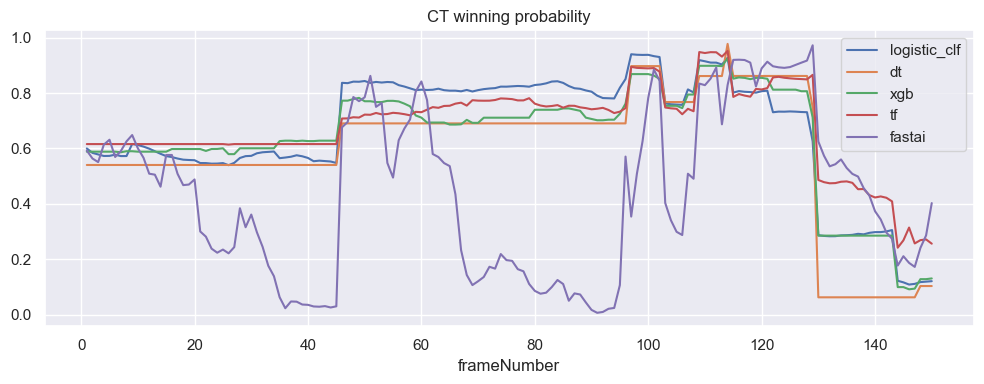

In [86]:
plt.subplots(figsize=(10,4))
show_predict_proba(['logistic_clf', 'dt', 'xgb', 'tf', 'fastai'], 
                   demoId, round_num, df_train_result, df_test_result)
plt.tight_layout()

In [87]:
%%html
<center><video width="400" height="400" autoplay loop controls>
  <source src="demos/demo_round_with_explanation.mp4" type="video/mp4">
</video></center>

## Unsupervised Learning

There are features that are highly correlated with each other in the data. For example, the total amount of Hp and Armor of a team would scale with the number of players alive on each team. In this section we investigate the effectiveness of dimensionality reduction using PCA and autoencoders.

### Dimensionality Reduction using PCA

We drop the nominal variables `bombsite`, `all_t_players_eliminated`, `bombPlanted` and `tHasBomb`.

In [88]:
X_train_num = X_train.drop(['bombsite', 'all_t_players_eliminated', 'bombPlanted', 'tHasBomb'], axis=1)
X_test_num = X_test.drop(['bombsite', 'all_t_players_eliminated', 'bombPlanted', 'tHasBomb'], axis=1)

The training data is already normalized from the previous section, so we can apply PCA directly.

In [89]:
from sklearn.decomposition import PCA
pca = PCA()

In [90]:
pca.fit(X_train_num)

PCA()

In [91]:
print('Original shape of the training data: {}'.format(X_train_num.shape))

# Determine the cumulative explained variance
cum_sum_eigenvalues = np.cumsum(pca.explained_variance_ratio_).round(6)
explained_variance = dict()
for p in np.linspace(0.86, 1, 8):
    j = np.argwhere(cum_sum_eigenvalues >= p).flatten().min()+1
    explained_variance[p] = [j]
explained_variance = pd.DataFrame(explained_variance).T
explained_variance.columns = ['Cumulative PC']
explained_variance.index.name = 'Explained Variance'
# explained_variance


Original shape of the training data: (744964, 28)


We apply dimensionality reduction by using the first `m` eigenvectors that explain at least 90% of the variance.

In [92]:
explained_var_threshold = 0.9
m = np.argwhere(cum_sum_eigenvalues >= explained_var_threshold).flatten().min()+1
pca_reduce = PCA(n_components=m)
pca_reduce.fit(X_train_num)

PCA(n_components=12)

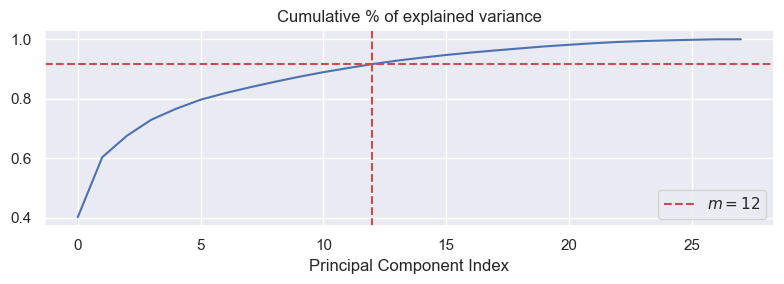

In [93]:
plt.subplots(figsize=(8,3))
plt.plot(cum_sum_eigenvalues)
plt.title('Cumulative % of explained variance')
plt.axvline(x=m, c='r', ls='--', label=r'$m={}$'.format(m))
plt.axhline(y=cum_sum_eigenvalues[m], c='r', ls='--')
plt.legend()
plt.xlabel('Principal Component Index')
plt.tight_layout()

In [94]:
X_train_PCA = pca_reduce.transform(X_train_num)
X_test_PCA = pca_reduce.transform(X_test_num)
print('Shape of the training data after PCA transform: {}'.format(X_train_PCA.shape))
print('Shape of the test data after PCA transform: {}'.format(X_test_PCA.shape))

Shape of the training data after PCA transform: (744964, 12)
Shape of the test data after PCA transform: (187779, 12)


We investigate the contribution of each feature to the first few principal components below. As expected, the first three principal components captured the correlation of the team-specific features, such as number of players alive, total amount of Hp and Armor.

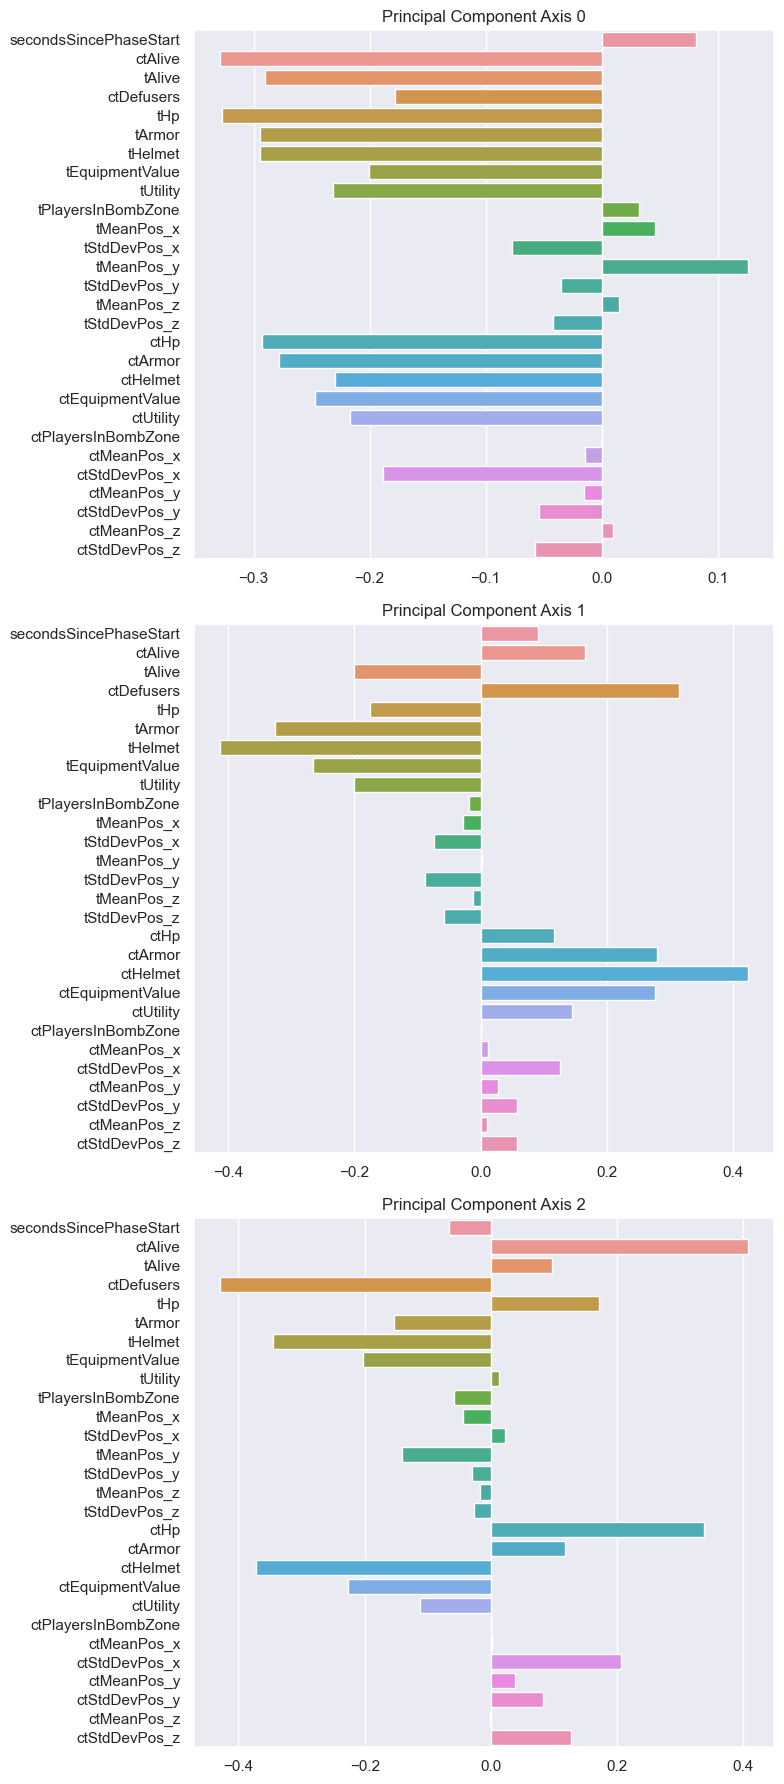

In [95]:
first_k_components = 3

fig, ax = plt.subplots(first_k_components, 1, figsize=(8, 18))
for i in range(first_k_components):
    sns.barplot(x=pca.components_[i], y=X_train_num.columns, orient='h', ax=ax[i])
    ax[i].set_title('Principal Component Axis {}'.format(i))

plt.tight_layout()

### Dimensionality Reduction using autoencoder

In [96]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense

Since the numerical variables in the training data and test data are normalized using `MinMaxScaler()`, we can use the sigmoid activation function in the final layer of our autoencoder.

From the PCA results, using the first 12 principal components captures 90% of the variance of the training data. In the autoencoder, we will use the same number of latent dimensions to see if the autoencoder can outperform PCA.

In [97]:
# Set the dimension of the latent layer and output layer
ncol = X_train_num.shape[1]
latent_dim = X_train_PCA.shape[1] # Use the same number of latent dimensions as PCA

def encoder(x):
    x = Dense(units=64, activation='sigmoid')(x)
    x = Dense(units=latent_dim, activation='sigmoid')(x)
    return x

def decoder(x):
    x = Dense(units=64, activation='sigmoid')(x)
    x = Dense(units=ncol, activation='sigmoid')(x)
    return x

In [98]:
x = Input(shape=(ncol,))
z = encoder(x)
x_recon = decoder(z)

autoencoder = Model(inputs=x, outputs=x_recon)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [99]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_6 (Dense)             (None, 64)                1856      
                                                                 
 dense_7 (Dense)             (None, 12)                780       
                                                                 
 dense_8 (Dense)             (None, 64)                832       
                                                                 
 dense_9 (Dense)             (None, 28)                1820      
                                                                 
Total params: 5,288
Trainable params: 5,288
Non-trainable params: 0
_________________________________________________________________


We train the autoencoder on the training data.

In [100]:
if RUN_MODELS_AGAIN == True:
    history = autoencoder.fit(X_train_num, X_train_num, epochs=20, batch_size=256)
    # Save the autoencoder
    autoencoder.save('models/autoencoder')
else:
    autoencoder = tf.keras.models.load_model('models/autoencoder')

Get the trained encoder and decoder layers from the autoencoder.

In [101]:
encoder_model = Sequential()
encoder_model.add(Input(shape=(ncol,)))
encoder_model.add(autoencoder.get_layer(index=1))
encoder_model.add(autoencoder.get_layer(index=2))
encoder_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                1856      
                                                                 
 dense_10 (Dense)            (None, 12)                780       
                                                                 
Total params: 2,636
Trainable params: 2,636
Non-trainable params: 0
_________________________________________________________________


In [102]:
decoder_model = Sequential()
decoder_model.add(Input(shape=(latent_dim,)))
decoder_model.add(autoencoder.get_layer(index=3))
decoder_model.add(autoencoder.get_layer(index=4))
decoder_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 64)                832       
                                                                 
 dense_12 (Dense)            (None, 28)                1820      
                                                                 
Total params: 2,652
Trainable params: 2,652
Non-trainable params: 0
_________________________________________________________________


### Comparison between PCA and autoencoder

We generate the reconstructed training data after dimensionality reduction and measure the difference with the original using RMSE.

For PCA, apply the transform and then the inverse transform on the training data.

In [103]:
# For PCA, apply the transform and then the inverse transform
X_train_recon_PCA = pd.DataFrame(pca_reduce.inverse_transform(pca_reduce.transform(X_train_num)), columns=X_train_num.columns)

For autoencoder, predict using the encoder and decoder sequentially on the training data.

In [104]:
# Encode the training data
X_train_encoded = encoder_model.predict(X_train_num)

# Decode the encoded data
X_train_recon = decoder_model.predict(X_train_encoded)
X_train_recon = pd.DataFrame(X_train_recon, columns=X_train_num.columns)

23281/23281 [==============================] - 15s 657us/step


The plot below shows the distribution of two features after being reconstructed by the PCA and autoencoder. We can see that the overall shape of the density is preserved, but it is not perfect (some information is lost).

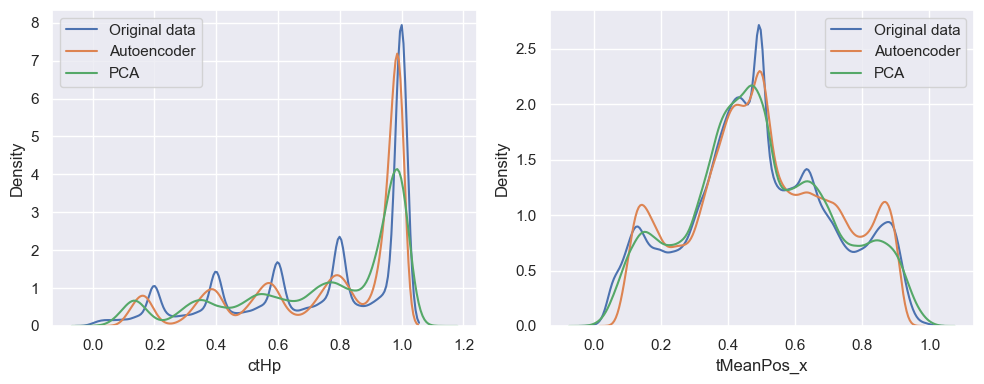

In [105]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))

sns.kdeplot(data=X_train_num, x='ctHp', ax=ax[0], label='Original data')
sns.kdeplot(data=X_train_recon, x='ctHp', ax=ax[0], label='Autoencoder')
sns.kdeplot(data=X_train_recon_PCA, x='ctHp', ax=ax[0], label='PCA')
ax[0].legend()

sns.kdeplot(data=X_train_num, x='tMeanPos_x', ax=ax[1], label='Original data')
sns.kdeplot(data=X_train_recon, x='tMeanPos_x', ax=ax[1], label='Autoencoder')
sns.kdeplot(data=X_train_recon_PCA, x='tMeanPos_x', ax=ax[1], label='PCA')
ax[1].legend()

plt.tight_layout()

Below shows the RMSE of the reconstructed data compared to the original. We can see that the autoencoder has a lower RMSE. This suggests that the autoencoder has a more efficient representation of the original data in the latent space.

In [106]:
mse = tf.keras.losses.MeanSquaredError()

print('Training set:')
print('Autoencoder latent space dimension: {}'.format(X_train_encoded.shape[1]))
print('Autoencoder reconstruction RMSE: {:.4%}'.format(np.sqrt(mse(X_train_num, X_train_recon))))
print('')
print('PCA latent space dimension: {}'.format(X_train_PCA.shape[1]))
print('PCA reconstruction RMSE: {:.4%}'.format(np.sqrt(mse(X_train_num, X_train_recon_PCA))))

Training set:
Autoencoder latent space dimension: 12
Autoencoder reconstruction RMSE: 5.6720%

PCA latent space dimension: 12
PCA reconstruction RMSE: 7.4172%


We compare apply the same reconstruction on test set and compare the RMSE. Again, the autoencoder has a lower RMSE.

In [107]:
# PCA
X_test_PCA = pca_reduce.transform(X_test_num)
X_test_recon_PCA = pd.DataFrame(pca_reduce.inverse_transform(X_test_PCA), columns=X_test_num.columns)

In [108]:
# Autoencoder
# Encode the training data
X_test_encoded = encoder_model.predict(X_test_num)

# Decode the encoded data
X_test_recon = decoder_model.predict(X_test_encoded)
X_test_recon = pd.DataFrame(X_test_recon, columns=X_test_num.columns)

5869/5869 [==============================] - 4s 656us/step


In [109]:
print('Test set:')
print('Autoencoder latent space dimension: {}'.format(X_test_encoded.shape[1]))
print('Autoencoder reconstruction RMSE: {:.4%}'.format(np.sqrt(mse(X_test_num, X_test_recon))))
print('')
print('PCA latent space dimension: {}'.format(X_test_PCA.shape[1]))
print('PCA reconstruction RMSE: {:.4%}'.format(np.sqrt(mse(X_test_num, X_test_recon_PCA))))

Test set:
Autoencoder latent space dimension: 12
Autoencoder reconstruction RMSE: 5.7383%

PCA latent space dimension: 12
PCA reconstruction RMSE: 7.4593%


## Summary and Limitations

**Summary.** In this project, we demonstrated the use of different supervised learning models to predict the winning probability of the Counter-Terrorist team given a game frame. We found that the logistic regression models, tree boosting method (XGBoost) and TensorFlow's neural network produced very similar performance.

We also compared the performances of PCA and Autoencoder and found that autoencoder is more efficient at representing the data in a lower-dimension latent space.

**Limitations.** We did not consider player-specific coordinates in the modeling, rather we aggregated the information at the team level using mean and standard deviation. It is possible to consider more complex models where model is able to learn the player-specific data. Clustering may also be used to find patterns in the player positioning during the round and identify a player's tendencies and strategies.

---
## Appendix

### Notebook for parsing JSON data

The notebook for parsing the JSON data can be found here: [ESTA_JSON_Parsing.ipynb](ESTA_JSON_Parsing.ipynb)

## References

1. IEM Rio Major 2022 - CS:GO - Viewership, Overview, Prize Pool - Esports Charts. https://escharts.com/tournaments/csgo/intel-extreme-masters-xvii-rio-major-2022
2. Peter Xenopoulos. (2022). pnxenopoulos/esta: ESTA v1.0 (v1.0). Zenodo. https://doi.org/10.5281/zenodo.6613987